In [1]:
### Author: Alexander Davydov
# This notebook regenerates the example in Section V.A

import numpy as np
import cvxpy as cp

# Define the variables and constants
n = 3 # number of variables

# Use cvxpy to find the minimizer
def find_min(rt,Aeq,beq):
    x = cp.Variable(3)
    objective = cp.Minimize(cp.norm(x-rt)**2 )
    constraints = [Aeq @ x == beq]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return x.value, constraints[0].dual_value

# Find norm with respect to which the dynamics are contracting
def find_weight(A, alpha):
    P = cp.Variable((4,4), symmetric=True)
    objective = cp.Minimize(0)
    constraints = [P @ A + A.T @ P << 2*alpha*P,
                  P >> 0.5*np.eye(4)]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return P.value

def find_weight_ineq(jac1, jac2, alpha):
    P = cp.Variable((3,3), symmetric=True)
    objective = cp.Minimize(0)
    constraints = [P @ jac1 + jac1.T @ P << 2*alpha*P,
                   P @ jac2 + jac2.T @ P << 2*alpha*P,
                  P >> 0.5*np.eye(3),
                  P << 50*np.eye(3)]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    stat = prob.status
    if stat == "optimal":
        return P.value
    else:
        return np.array([0])

# Bisect to find optimal contraction rate and norm
def bisection_P(jac1,jac2, lower, upper):
    while(upper - lower > 0.02):
        guess = 0.5*(upper + lower)
        P = find_weight_ineq(jac1,jac2,guess)
        if P.all() == 0:
            lower = guess
        else:
            upper = guess
    return find_weight_ineq(jac1,jac2,upper), upper

# Solve for the time-varying equilibrium point
def eq_primal_dual(theta1, theta2):
    A = np.array([[-1, 0, 0, -1], [0, -1, 0, -2], [0, 0, -1, -1], [1, 2, 1, 0]])
    return np.linalg.solve(A, np.array([-theta1, -theta2, -1, theta1]))

In [35]:
import matplotlib.pyplot as plt

n = 3
w = 0.2
mu = w
T = 4500

# Time-varying parameter
r = lambda t: np.array([np.sin(w*t), np.cos(w*t), 1])
# Objective
obj = lambda x, t: 0.5 * np.linalg.norm(x - r(t))**2
# Gradient of the objective
obj_grad = lambda x, t: x - r(t)
# Lagrangian
lag = lambda x, lam, t: obj(x, t) + lam*(Aeq(t) @ x - beq(t))
# Gradient of the Lagrandian
lag_grad = lambda x, lam, t: np.concatenate((obj_grad(x, t) + lam * Aeq(t), Aeq(t) @ x - beq(t)), axis=None)

# Matrix and vector defining the equality constraint
Aeq = lambda t: np.array([1, 2, 1])
beq = lambda t: np.sin(w*t)

# Jacobian matrix for the dynamics
A = np.array([[-1, 0, 0, -1], [0, -1, 0, -2], [0, 0, -1, -1], [1, 2, 1, 0]])

# Define arrays to store intermediate variables
dt = 0.01
xs = np.zeros((n, T))
xopts = np.zeros((n,T))
lamopts = np.zeros((1,T))
zopts = np.zeros((n+1,T))
lams = np.zeros((1,T))
times = np.zeros((1,T))
lagnorms = np.zeros((1,T))
weightnorms = np.zeros((1,T))


xopts[:,0], lamopts[:,0] = find_min(r(0),Aeq(0),beq(0))
zopts[:,0] = eq_primal_dual(np.sin(0),np.cos(0))


for i in range(T-1):
    # Euler integrate the continuous dynamics
    tc = times[:,i]
    xc = xs[:, i]
    tc = np.squeeze(tc)
    lamc = lams[:,i]
    xk = xc - dt*(obj_grad(xc, tc) + Aeq(tc) * lamc)
    lamk = lamc + dt*(Aeq(tc) @ xc - beq(tc))
    lagnormk = np.linalg.norm(lag_grad(xc, lamc, tc))
    xs[:,i+1] = xk
    lams[:,i+1] = lamk
    times[:,i+1] = tc + dt
    lagnorms[:,i+1] = lagnormk
    xopts[:,i+1], lamopts[:,i+1] = find_min(r(tc),Aeq(tc),beq(tc))
    # Use zopts as the time-varying equilibrium point
    zopts[:,i+1] = eq_primal_dual(r(tc)[0],r(tc)[1])
    
# Print the errors at the end
print('norm of the gradient of the Lagrangian at the end:', lagnorms[:,-1])
print('primal variable error at the end:', np.linalg.norm(xs[:,-1]-xopts[:,-1]))

norm of the gradient of the Lagrangian at the end: [0.13749924]
primal variable error at the end: 0.11477129207909054


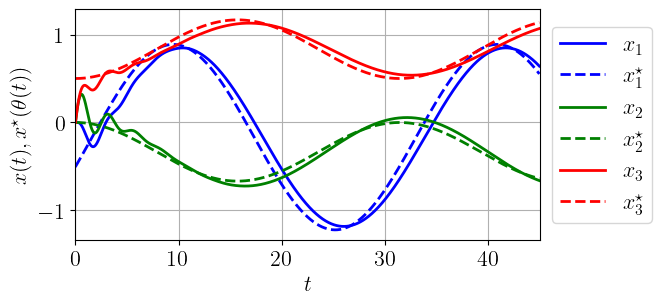

In [36]:
from matplotlib import rc
plt.rcParams.update({'font.size': 16})
rc('text', usetex=True)

xopts = zopts[:-1,:]

# Plot primal variables
fig, ax = plt.subplots(figsize=(6, 3))
ax.grid()
ax.plot(times.T, xs[0,:].T, 'b', linewidth=2, label=r'$x_1$')
ax.plot(times.T,xopts[0,:].T, 'b--', linewidth=2, label=r'$x_1^{\star}$')
ax.plot(times.T, xs[1,:].T, 'g', linewidth=2, label=r'$x_2$')
ax.plot(times.T,xopts[1,:].T, 'g--', linewidth=2, label=r'$x_2^{\star}$')
ax.plot(times.T, xs[2,:].T, 'r', linewidth=2, label=r'$x_3$')
ax.plot(times.T,xopts[2,:].T, 'r--', linewidth=2, label=r'$x_3^{\star}$')
plt.xlim(0, 45.1)

plt.xlabel(r'$t$')
plt.ylabel(r'$x(t), x^{\star}(\theta(t))$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

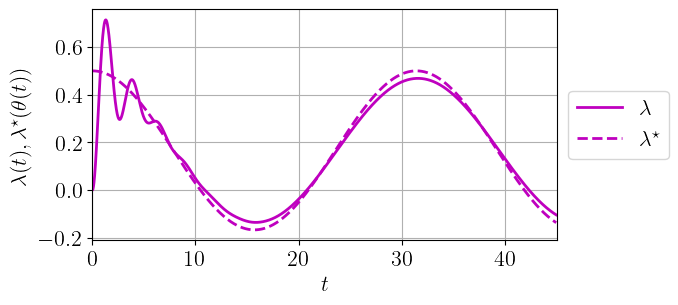

In [39]:
# Optimal dual variable
lamopts = zopts[3,:]

fig, ax = plt.subplots(figsize=(6, 3))

# Plot dual variable
ax.grid()
ax.plot(times.T, lams[0,:].T, 'm', linewidth=2, label=r'$\lambda$')
ax.plot(times.T,lamopts.T, 'm--', linewidth=2, label=r'$\lambda^{\star}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, 45.1)

plt.xlabel(r'$t$')
plt.ylabel(r'$\lambda(t), \lambda^{\star}(\theta(t))$')
plt.show()

norm with respect to which we are contracting: [[0.754313   0.03005797 0.01502996 0.06910114]
 [0.03005797 0.79940053 0.03005797 0.13820187]
 [0.01502996 0.03005797 0.754313   0.06910114]
 [0.06910114 0.13820187 0.06910114 0.83200739]]
upper bound: 0.7219659388525962


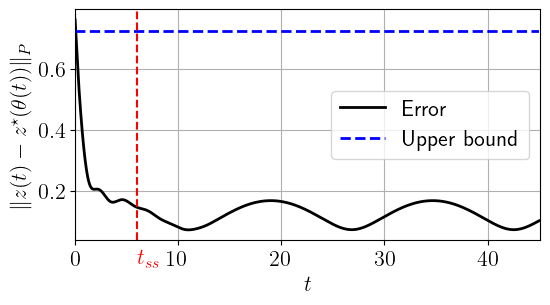

In [44]:
from scipy.linalg import sqrtm

zs = np.vstack((xs,lams))
#zopts = np.vstack((xopts,lamopts))
errs = zs - zopts

# Jacobian matrix (it is constant in this case)
jacx = np.array([[-1, 0, 0, -1], [0, -1, 0, -2], [0, 0, -1, -1], [1, 2, 1, 0]])
val, vec = np.linalg.eig(jacx)
# Optimal contraction rate is the spectral abscissa of A
c = np.max(np.real(val))
# Find the norm with respect to which we are contracting
P = find_weight(jacx, c + 0.01)
val, vec = np.linalg.eig(P)
P = P/np.max(val)

print('norm with respect to which we are contracting:', P)
# Compute weighted errors
for i in range(len(errs[0,:])):
    erri = np.array([errs[:,i]])
    weightnorms[:,i] = np.sqrt(erri @ P @ erri.T)

Phalf = sqrtm(P)
jac = np.array([[1, 0],[0, 1], [0, 0], [0, 0]])
# Lipschitz estimate
lip = np.linalg.norm(Phalf @ jac, 2)

# Upper bound based on Theorem 2
uub = w*lip/(c**2)
print('upper bound:', uub)

fig, ax = plt.subplots(figsize=(6, 3))

ax.grid()
ax.plot(times.T, weightnorms[:].T, 'k', linewidth=2, label='Error')
ax.plot(times.T, np.ones(T)*uub, 'b--', linewidth=2, label='Upper bound')
ax.axvline(x=6, color='red', linestyle='--')
ax.text(6, -0.04, r'$t_{ss}$', color='red', fontsize=16)
plt.legend()
plt.xlim(0, 45.1)

plt.xlabel(r'$t$')
plt.ylabel(r'$\|z(t) - z^{\star}(\theta(t))\|_{P}$')
plt.show()